
<h1 style="text-align: center;">Assignment - 2</h1>
<div style="display: flex; justify-content: space-between;">
  <div style="text-align: left;">
    <strong>Roll No:</strong> 241110035<br>
    <strong>Name:</strong> Khushwant Kaswan
  </div>
  <div style="text-align: center;">
    <strong>CS724: SENSING COMMUNICATIONS AND </strong> <br>
    <strong>NETWORKING FOR SMART WIRELESS DEVICES</strong>
  </div>
  <div style="text-align: right;">
    <strong>IIT Kanpur</strong><br>
    <strong>MTech CSE</strong>

  </div>
</div>
<hr />

In [ ]:
# Installing all libraries
%pip install numpy pandas matplotlib scipy plotly scikit-learn


In [1]:
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import plotly.graph_objects as go
from numpy.fft import fft, fftfreq

## Q1. Spectogram

Spectrogram of Audio File

## (a)

## (b)

In [3]:
def create_spectrogram(filename, frame_size=2048, overlap=1024):
    sample_rate, audio_data = wavfile.read(filename)

    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]

    hop_size = frame_size - overlap
    num_frames = int(np.ceil((len(audio_data) - overlap) / hop_size))
    spectrogram = np.zeros((frame_size // 2, num_frames))
    window = np.hamming(frame_size)

    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size

        if end > len(audio_data):
            frame = audio_data[start:]  # Handle last frame which is shorter
            frame = np.pad(frame, (0, frame_size - len(frame)), 'constant')  # Zero padding
        else:
            frame = audio_data[start:end]

        frame = frame * window
        fft_result = fft(frame)
        magnitude = np.abs(fft_result[:frame_size // 2])
        magnitude=np.real(magnitude*np.conj(magnitude))
        spectrogram[:, i] = magnitude

    spectrogram = 10 * np.log10(spectrogram + 1e-10)


    num_frames = spectrogram.shape[1]
    frequencies = fftfreq(frame_size, 1 / sample_rate)[:frame_size // 2]
    times = np.arange(num_frames) * hop_size / sample_rate


    plt.figure(figsize=(12, 6))
    plt.pcolormesh(times, frequencies, spectrogram, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title('Spectrogram')
    plt.ylim(0, 5000)
    plt.show()


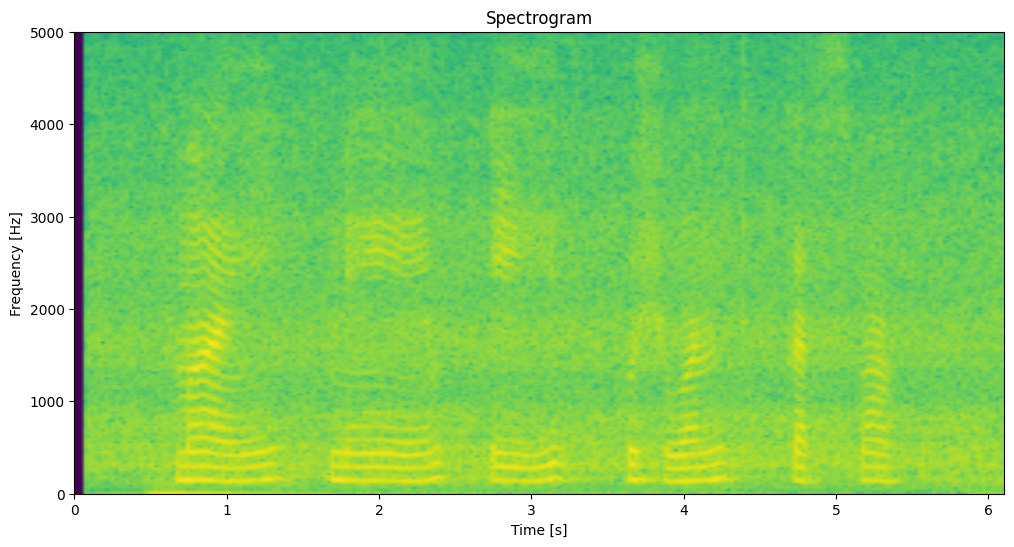

In [4]:
create_spectrogram('audio.wav')

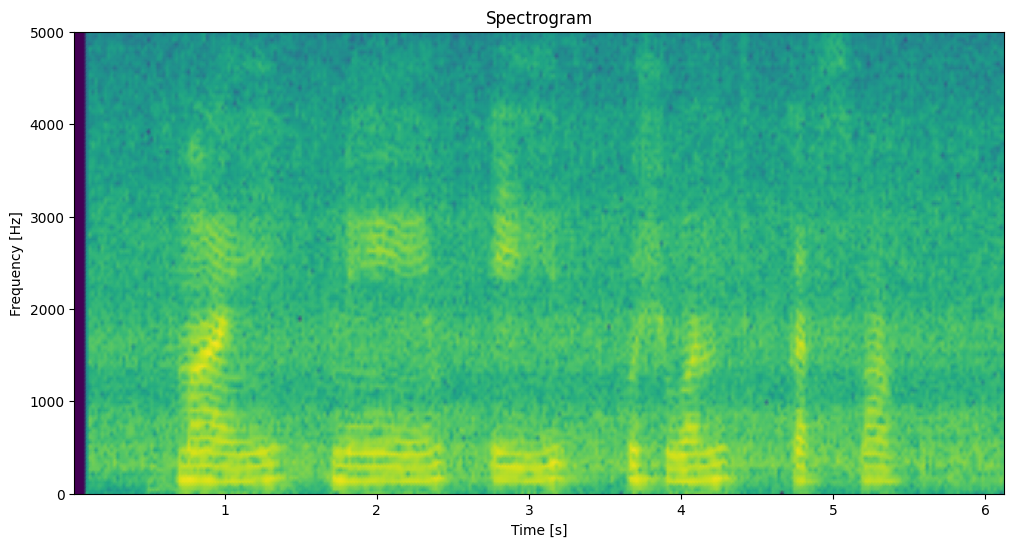

In [5]:
# Verification of spectogram scipy library

from scipy.signal import spectrogram

sample_rate, audio_data = wavfile.read('audio.wav')

# Ensure audio data is mono (single channel)
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

frequencies, times, Sxx = spectrogram(audio_data, fs=sample_rate, nperseg=1024)
Sxx_dB = 10 * np.log10(Sxx + 1e-8)


plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, Sxx_dB, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram')
plt.ylim(0, 5000)
plt.show()


## (c)

Both spectograms(self and scipy generated) are completly same except the color difference.

Horizontal lines or bands represent frequencies that remain constant during a particular time interval.

Changes in frequency patterns over time (e.g., the appearance and disappearance of frequency bands) typically correspond to different spoken words or sounds in the audio.
 
Each "block" of the spectrogram reflects the frequency content of the audio at that time ie individual words as they are spoken ie "My name is Khushwant Kaswan".  

So, the spectrogram indeed shows the time-frequency structure of speech, with each "spectrum" corresponding to a word or sound.

## Q2 Accelerometer

Use the accelerometer sensor of your smartphone to find out some simple human posture

## (a) 

Record the accelerometer samples while you are sitting, standing and lying down straight, and plot them

In [6]:
def plot_acc(csv_name):
    data = pd.read_csv(csv_name, header=0, names=['time','ax', 'ay', 'az','aT'])

    # print(data.head())
    trace_x = go.Scatter(x=data['time'],y=data['ax'], mode='lines', name='X-axis')
    trace_y = go.Scatter(x=data['time'],y=data['ay'], mode='lines', name='Y-axis')
    trace_z = go.Scatter(x=data['time'],y=data['az'], mode='lines', name='Z-axis')


    # print(trace_x)

    layout_x = go.Layout(
        title=f"Time V/S Accelerometer Readings for {csv_name} in x-direction",
        xaxis=dict(title="Time"),
        yaxis=dict(title="x-Acceleration (m/s²)"),
    )
    layout_y = go.Layout(
        title=f"Time V/S Accelerometer Readings for {csv_name} in y-direction",
        xaxis=dict(title="Time"),
        yaxis=dict(title="y-Acceleration (m/s²)"),
    )
    layout_z = go.Layout(
        title=f"Time V/S Accelerometer Readings for {csv_name} in in z-direction",
        xaxis=dict(title="Time"),
        yaxis=dict(title="z-Acceleration (m/s²)"),
    )
    layout = go.Layout(
        title=f"Time V/S Accelerometer Readings for {csv_name}",
        xaxis=dict(title="Time"),
        yaxis=dict(title="Acceleration (m/s²)"),
    )

    fig = go.Figure(data=[trace_x, trace_y, trace_z], layout=layout)
    fig.show()
    fig = go.Figure(data=[trace_x], layout=layout_x)
    fig.show()
    fig = go.Figure(data=[trace_y], layout=layout_y)
    fig.show()
    fig = go.Figure(data=[trace_z], layout=layout_z)
    fig.show()


In [7]:
plot_acc("Standing.csv")

In [8]:
plot_acc("Sitting.csv")

In [9]:
plot_acc("Sleeping.csv")

## (b)

Use this pattern for “finding out among these three human postures”
in real time

Process : 
We have used 3 different methods
- Using normal thresholding with threshold chosen as (min---max) values of the axis.
- Using normal thresholding with threshold chosen as (mean-2*SD---mean+2*SD) values of the axis.
- Using Random Forest Classifier based Machine Learning Approach

Created a test.csv containg 416 different test examples and we are going to classify them to "Sitting" "Sleeping" "Standing" and "Unknown"



### !!! Make sure the header of .csv files is **time,ax,ay,az,aT**

In [10]:
def load_data(file_path):
    data = pd.read_csv(file_path, header=0, names=["time",'ax', 'ay', 'az','aT'])
    return data

In [11]:
def calculate_statistics(data):
    stats = {
        'mean': data.mean(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max()
    }
    return stats

def print_statistics(posture, stats):
    print(f"Statistics for {posture}:")
    print(f"Mean:\n{stats['mean'][1:]}")
    print(f"Standard Deviation:\n{stats['std'][1:]}")
    print(f"Min:\n{stats['min'][1:]}")
    print(f"Max:\n{stats['max'][1:]}")
    print("\n")

In [12]:
def calculate_thresholds_min_max(sitting_stats, standing_stats, lying_stats):
    thresholds = {
        'X_SLEEP_THRESHOLD': (lying_stats['min']['ax'], lying_stats['max']['ax']),
        'Y_SLEEP_THRESHOLD': (lying_stats['min']['ay'], lying_stats['max']['ay']),
        'Z_SLEEP_THRESHOLD': (lying_stats['min']['az'], lying_stats['max']['az']),

        'X_SITTING_THRESHOLD': (sitting_stats['min']['ax'], sitting_stats['max']['ax']),
        'Y_SITTING_THRESHOLD': (sitting_stats['min']['ay'], sitting_stats['max']['ay']),
        'Z_SITTING_THRESHOLD': (sitting_stats['min']['az'], sitting_stats['max']['az']),

        'X_STANDING_THRESHOLD': (standing_stats['min']['ax'], standing_stats['max']['ax']),
        'Y_STANDING_THRESHOLD': (standing_stats['min']['ay'], standing_stats['max']['ay']),
        'Z_STANDING_THRESHOLD': (standing_stats['min']['az'], standing_stats['max']['az']),
    }
    return thresholds


In [13]:
def create_thresholds_mean_sd(lying_stats, sitting_stats, standing_stats):
    # mean ± 2 * SD.
    thresholds = {
        'X_SLEEP_THRESHOLD': (lying_stats['mean']['ax'] - 2 * lying_stats['std']['ax'],
                               lying_stats['mean']['ax'] + 2 * lying_stats['std']['ax']),
        'Y_SLEEP_THRESHOLD': (lying_stats['mean']['ay'] - 2 * lying_stats['std']['ay'],
                               lying_stats['mean']['ay'] + 2 * lying_stats['std']['ay']),
        'Z_SLEEP_THRESHOLD': (lying_stats['mean']['az'] - 2 * lying_stats['std']['az'],
                               lying_stats['mean']['az'] + 2 * lying_stats['std']['az']),

        'X_SITTING_THRESHOLD': (sitting_stats['mean']['ax'] - 2 * sitting_stats['std']['ax'],
                                 sitting_stats['mean']['ax'] + 2 * sitting_stats['std']['ax']),
        'Y_SITTING_THRESHOLD': (sitting_stats['mean']['ay'] - 2 * sitting_stats['std']['ay'],
                                 sitting_stats['mean']['ay'] + 2 * sitting_stats['std']['ay']),
        'Z_SITTING_THRESHOLD': (sitting_stats['mean']['az'] - 2 * sitting_stats['std']['az'],
                                 sitting_stats['mean']['az'] + 2 * sitting_stats['std']['az']),

        'X_STANDING_THRESHOLD': (standing_stats['mean']['ax'] - 2 * standing_stats['std']['ax'],
                                  standing_stats['mean']['ax'] + 2 * standing_stats['std']['ax']),
        'Y_STANDING_THRESHOLD': (standing_stats['mean']['ay'] - 2 * standing_stats['std']['ay'],
                                  standing_stats['mean']['ay'] + 2 * standing_stats['std']['ay']),
        'Z_STANDING_THRESHOLD': (standing_stats['mean']['az'] - 2 * standing_stats['std']['az'],
                                  standing_stats['mean']['az'] + 2 * standing_stats['std']['az']),
    }
    return thresholds


In [14]:
def automate_threshold_determination(choice):
    sitting_data = load_data('Sitting.csv')
    standing_data = load_data('Standing.csv')
    lying_data = load_data('Sleeping.csv')


    sitting_stats = calculate_statistics(sitting_data)
    standing_stats = calculate_statistics(standing_data)
    lying_stats = calculate_statistics(lying_data)

    # Print statistics for analysis
    # print_statistics('Sitting', sitting_stats)
    # print_statistics('Standing', standing_stats)
    # print_statistics('Lying Down', lying_stats)

    if choice=="minmax":
        thresholds = create_thresholds_mean_sd(sitting_stats, standing_stats, lying_stats)
    if choice=="meansd":
        thresholds = calculate_thresholds_min_max(sitting_stats, standing_stats, lying_stats)

    return thresholds

# choice="meansd"
choice="minmax"
thresholds = automate_threshold_determination(choice)

print(f"Thresholds using {choice}:")
for key, value in thresholds.items():
    print(f'{key}: {value}')

Thresholds using minmax:
X_SLEEP_THRESHOLD: (np.float64(-0.07601262981030535), np.float64(0.0688093308412332))
Y_SLEEP_THRESHOLD: (np.float64(-0.07622638670892268), np.float64(0.07004576815222166))
Z_SLEEP_THRESHOLD: (np.float64(-0.09945091017177374), np.float64(0.08130204419239229))
X_SITTING_THRESHOLD: (np.float64(-0.28559974872550026), np.float64(0.28449795946108675))
Y_SITTING_THRESHOLD: (np.float64(-0.14868076454295825), np.float64(0.15608235500021472))
Z_SITTING_THRESHOLD: (np.float64(-0.3549421168684677), np.float64(0.3283246218386467))
X_STANDING_THRESHOLD: (np.float64(-0.1745053045858415), np.float64(0.16223690631744322))
Y_STANDING_THRESHOLD: (np.float64(-0.13258737650349064), np.float64(0.15792720334331747))
Z_STANDING_THRESHOLD: (np.float64(-0.16315753219843665), np.float64(0.1403280949689994))


In [16]:
def classify_posture(x_acc, y_acc, z_acc, thresholds):

    if (thresholds['X_STANDING_THRESHOLD'][0] <= x_acc <= thresholds['X_STANDING_THRESHOLD'][1] and
        thresholds['Y_STANDING_THRESHOLD'][0] <= y_acc <= thresholds['Y_STANDING_THRESHOLD'][1] and
        thresholds['Z_STANDING_THRESHOLD'][0] <= z_acc <= thresholds['Z_STANDING_THRESHOLD'][1]):
        return "Standing"

    elif (thresholds['X_SITTING_THRESHOLD'][0] <= x_acc <= thresholds['X_SITTING_THRESHOLD'][1] and
        thresholds['Y_SITTING_THRESHOLD'][0] <= y_acc <= thresholds['Y_SITTING_THRESHOLD'][1] and
        thresholds['Z_SITTING_THRESHOLD'][0] <= z_acc <= thresholds['Z_SITTING_THRESHOLD'][1]):
        return "Sitting"

    elif (thresholds['X_SLEEP_THRESHOLD'][0] <= x_acc <= thresholds['X_SLEEP_THRESHOLD'][1] and
        thresholds['Y_SLEEP_THRESHOLD'][0] <= y_acc <= thresholds['Y_SLEEP_THRESHOLD'][1] and
        thresholds['Z_SLEEP_THRESHOLD'][0] <= z_acc <= thresholds['Z_SLEEP_THRESHOLD'][1]):
        return "Sleeping"

    else:
        return "Unknown"


def process_testing_data(file_path, choice):

    data = pd.read_csv(file_path, header=0, names=['t','ax', 'ay', 'az','aT'])
    print(f"Using {choice} thresholds")
    print(f"{'SNo':<6}{'ax':<12}{'ay':<12}{'az':<12}{'Posture':<12}")
    print("="*50)

    thresholds = automate_threshold_determination(choice)

    # Classify each row in the test data
    for index, row in data.iterrows():
        x_acc = row['ax']
        y_acc = row['ay']
        z_acc = row['az']

        posture = classify_posture(x_acc, y_acc, z_acc, thresholds)
        print(f"{index+1:<6}{x_acc:<12.4f}{y_acc:<12.4f}{z_acc:<12.4f}{posture:<12}")

file_path = "Test.csv"
# choice="minmax"
choice="meansd"
process_testing_data(file_path, choice)


Using meansd thresholds
SNo   ax          ay          az          Posture     
1     0.0031      -0.0253     0.1412      Standing    
2     0.4193      -4.9210     -0.8440     Unknown     
3     -0.3709     -1.1664     0.9668      Unknown     
4     2.7903      0.4226      1.3831      Unknown     
5     1.1368      0.0837      0.4272      Unknown     
6     2.6244      0.1059      -1.6480     Unknown     
7     4.8386      -2.2122     4.5807      Unknown     
8     3.4710      1.0699      -1.5718     Unknown     
9     0.9477      2.1898      -1.9411     Unknown     
10    -1.1141     0.7250      -0.2694     Unknown     
11    -0.1970     -0.6247     1.2076      Unknown     
12    -2.5819     0.1456      -0.6227     Unknown     
13    -1.7483     -2.2014     -0.0063     Unknown     
14    -3.1802     -2.3740     0.4016      Unknown     
15    -2.9738     -3.9254     -0.0971     Unknown     
16    -2.8121     -3.8173     0.9375      Unknown     
17    -3.0900     -1.7953     1.3963     

## Using Random Forest Classifier

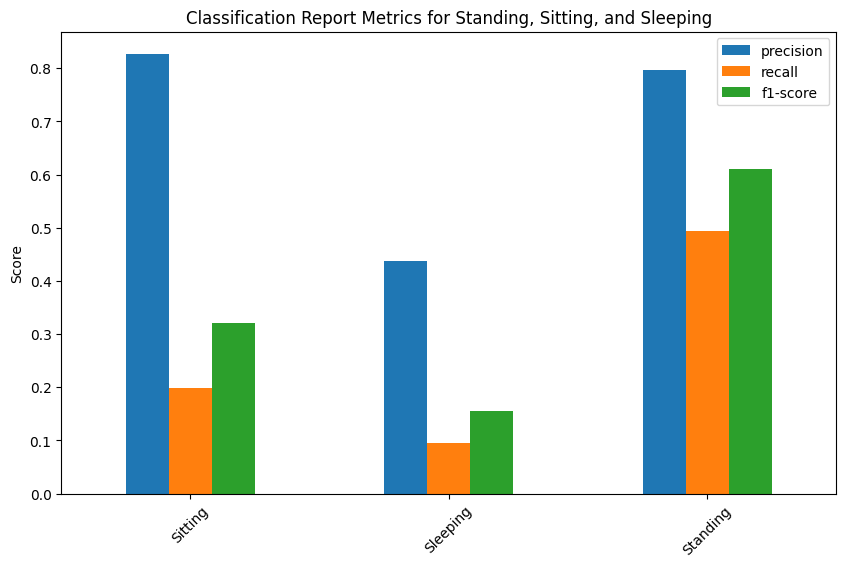

Line  ax          ay          az          Posture     
1     0.0031      -0.0253     0.1412      Standing    
2     0.4193      -4.9210     -0.8440     Standing    
3     -0.3709     -1.1664     0.9668      Unknown     
4     2.7903      0.4226      1.3831      Standing    
5     1.1368      0.0837      0.4272      Standing    
6     2.6244      0.1059      -1.6480     Standing    
7     4.8386      -2.2122     4.5807      Unknown     
8     3.4710      1.0699      -1.5718     Unknown     
9     0.9477      2.1898      -1.9411     Unknown     
10    -1.1141     0.7250      -0.2694     Unknown     
11    -0.1970     -0.6247     1.2076      Unknown     
12    -2.5819     0.1456      -0.6227     Standing    
13    -1.7483     -2.2014     -0.0063     Unknown     
14    -3.1802     -2.3740     0.4016      Unknown     
15    -2.9738     -3.9254     -0.0971     Unknown     
16    -2.8121     -3.8173     0.9375      Unknown     
17    -3.0900     -1.7953     1.3963      Unknown     
18    -1.5

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

standing = pd.read_csv('Standing.csv')
sitting = pd.read_csv('Sitting.csv')
lying = pd.read_csv('Sleeping.csv')
test_data = pd.read_csv('Test.csv')

standing['posture'] = 'Standing'
sitting['posture'] = 'Sitting'
lying['posture'] = 'Sleeping'

data = pd.concat([standing, sitting, lying])
X = data[['ax', 'ay', 'az']]
y = data['posture']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


y_pred_proba = clf.predict_proba(X_val)
confidence_threshold = 0.7

class_names = clf.classes_

y_pred = np.where(np.max(y_pred_proba, axis=1) >= confidence_threshold, class_names[np.argmax(y_pred_proba, axis=1)], 'Unknown')
X_test = test_data[['ax', 'ay', 'az']]
y_test_pred_proba = clf.predict_proba(X_test)
test_data['predicted_posture'] = np.where(np.max(y_test_pred_proba, axis=1) >= confidence_threshold, class_names[np.argmax(y_test_pred_proba, axis=1)], 'Unknown')


report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
df = pd.DataFrame(report).transpose()
df = df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0, errors='ignore')
df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics for Standing, Sitting, and Sleeping')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


# Printing formatted reults
print(f"{'Line':<6}{'ax':<12}{'ay':<12}{'az':<12}{'Posture':<12}")
print("="*50)
for index, row in test_data.iterrows():
        x_acc = row['ax']
        y_acc = row['ay']
        z_acc = row['az']
        posture = row['predicted_posture']
        print(f"{index+1:<6}{x_acc:<12.4f}{y_acc:<12.4f}{z_acc:<12.4f}{posture:<12}")
